Model the window correction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nbodykit.lab as nb
import nbodykit
import fitsio as ft
from time import time
from   glob import glob
import mcfit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
plt.rc('font', size=20)

In [55]:
from scipy.special import legendre

def RR_to_ell(RR, mu_bins, ell):
    mu_mid       = 0.5*(mu_bins[:-1]+mu_bins[1:])
    legendre_pol = (2*ell+1.)*legendre(ell)(mu_mid)
    mu_diff      = np.diff(mu_bins) 
    result       = RR * legendre_pol * mu_diff
    print(result.shape)
    RR_ell       = np.sum(result, axis=-1) / np.sum(mu_bins)
    return RR_ell    

def plot_RRellr(RR):    
    for ell in [0, 2, 4]:
        x   = RR.pairs.edges['r']
        y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
        dx  = np.diff(x)
        xc  = 0.5*(x[1:]+x[:-1])
        vol = 4*np.pi*xc**2*dx    
        y  /= vol
        #print(y[0])
        #y /= y[3]
        plt.plot(xc, y, label='ell=%d'%ell)
    plt.legend()
    plt.xscale('log')
    plt.xlim(10, 4e3)
    #plt.ylim(-1.5, 1.1)
    # plt.xlim(xmin=1)
    

def read_florian():    
    lbls = 'W^0_0(k) W^0_1(k) W^0_2(k) W^0_3(k) W^0_4(k) W^1_0(k)'\
        +' W^1_1(k) W^1_2(k) W^1_3(k) W^1_4(k) W^2_0(k) W^2_1(k) W^2_2(k) W^2_3(k) W^2_4(k) Nmodes'
    tlb = lbls.split(' ')    
    d = np.loadtxt('/home/mehdi/data/eboss/v6/win_eBOSS_DR16_QSO_v6_NGC_TSC_600_600_600_10000_merged.dat', 
                   skiprows=30)
    w_dicts = {}
    for i, j in enumerate(range(2, 17)):
        k = d[:, 0]
        w = d[:, j]
        w_dicts[tlb[i]] = w
    return k, w_dicts    



def plot_W0ellr(k, w_dicts, ax=None):
    Klog = np.logspace(np.log10(k.min()), np.log10(2.0), num=1024, endpoint=True)
    if ax is None:
        fig,ax = plt.subplots(figsize=(8, 6))
    for ell in [0, 2, 4]:#, 1, 2, 3, 4]:
        wius = IUS(k, w_dicts['W^0_%d(k)'%ell], ext=1)
        wk   = wius(Klog)        
        print(Klog[-10:], wk[-10:])
        #for i in range(Klog.size):
        #    print([Klog[i], wk[i]])
        #break
        r, wr = mcfit.P2xi(Klog, l=ell)(wk)
        sf = 1 if ell==2 else 1
        ax.plot(r, sf*wr, label=r'$W^0_%d$'%ell)
    ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    ax.set_xlim(10, 4e3)
    # plt.ylim(0, 2.e-10)
    ax.set_xlabel('r')
    ax.legend(fontsize=20)
    
    
def plot_W0ellk(k, w_dicts, ax=None):
    if ax is None:fig, ax = plt.subplots(figsize=(8, 6))
    for l in [0]:#, 1, 2, 3, 4]:
        w = w_dicts['W^0_%d(k)'%l]
        ax.plot(k, w, label=r'$W^0_%d$'%l, marker='.')

    #ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    #ax.set_xlim(1.e-4, 2e-2)
    #ax.set_xlim(1.e-4, 0.5)
    #plt.ylim(0, 2.e-10)
    ax.set_xlabel('k')
    ax.legend(fontsize=20)    
    
    
def plot_RRr(RR):
    dr = np.diff(edges)
    plt.plot(edges[:-1], RR1d.pairs['wnpairs']/ ((4*np.pi*edges[:-1]**2*dr)))
    plt.xscale('log')
    plt.xlim(xmin=1)    
    
    
def plot_RRrmu(RR):
    for j, mu_j in enumerate(RR.pairs.edges['mu'][:-1]):
        #print(j)
        plt.plot(RR.pairs.edges['r'][:-1], RR.pairs['wnpairs'][:, j], label=r'$\mu$=%.1f'%mu_j)
    plt.legend(bbox_to_anchor=(1.1, 1.1))
    plt.ylabel('RR(r)')
    plt.xlabel('r')        

## read the randoms catalog

In [12]:
#randoms = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits', lower=True)
randoms = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6_100k.ran.fits', lower=True)
randoms.dtype.names

('ra',
 'dec',
 'z',
 'weight_fkp',
 'weight_systot',
 'weight_cp',
 'weight_noz',
 'nz')

In [15]:
# randoms = np.random.choice(randoms, size=10000, replace=False)
randoms = nb.ArrayCatalog(randoms)
randoms.columns
randoms['Weight'] = randoms['weight_cp']*randoms['weight_noz']*randoms['weight_systot']*randoms['weight_fkp']
randoms.size

['Selection',
 'Value',
 'Weight',
 'dec',
 'nz',
 'ra',
 'weight_cp',
 'weight_fkp',
 'weight_noz',
 'weight_systot',
 'z']

In [19]:
def run():
    t0 = time()    
    edges = np.logspace(np.log10(0.1), np.log10(5000.0), 100)
    # edges = np.linspace(0.001, 5000.0, 100)
    cosmo = nb.cosmology.Planck15
    RR    = nb.SurveyDataPairCount('2d', randoms, edges, Nmu=20, cosmo=cosmo, 
                                   ra='ra', dec='dec', redshift='z', weight='Weight',
                                   show_progress=1)
    print('took {} sec'.format(time()-t0))
    return RR
RR = run()
RR.save('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6_100k.RR.ran.json')

took 266.39410305023193 sec


0.0
0.0
0.0


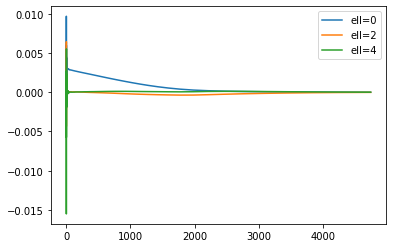

In [27]:
for ell in [0, 2, 4]:
    x   = RR.pairs.edges['r']
    y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
    dx  = np.diff(x)
    xc  = 0.5*(x[1:]+x[:-1])
    vol = 4*np.pi*xc**2*dx    
    y  /= vol
    print(y[0])
    plt.plot(xc, y, label='ell=%d'%ell)
plt.legend()
# plt.xscale('log')
# plt.xlim(xmin=1)

Use SurveyDataPairCount and use Nmu= 100
Inside this SurveyDataPairCount, modify the option for 1d.
And made mode 2d

Make your code so that it addes all different mu bins aftermultiply with Legendre_ell(mu)


In [77]:
edges   = np.logspace(np.log10(0.1), np.log10(5000.0), 100)
# edges = np.linspace(0.001, 5000.0, 100)
cosmo   = nb.cosmology.Planck15
RR1d    = nb.SurveyDataPairCount('1d', randoms, edges, cosmo=cosmo, 
                               ra='ra', dec='dec', redshift='z', weight='Weight',
                               show_progress=True)

(1, 7657.393122730506)

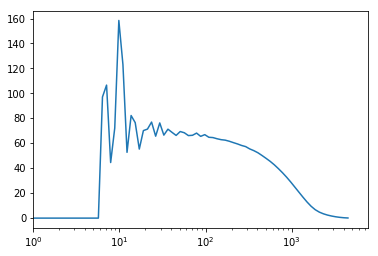

In [86]:
dr = np.diff(edges)
plt.plot(edges[:-1], RR1d.pairs['wnpairs']/ ((4*np.pi*edges[:-1]**2*dr)))
plt.xscale('log')
plt.xlim(xmin=1)

## Florian's vs. HJ's Paircount

In [4]:
path2file = '/C/sheejong/Shared/eBOSS_QSO_clustering_NGC_v6.ran'
RR = nb.SurveyDataPairCount.load(path2file)
#RRj = nbodykit.algorithms.paircount_tpcf.estimators.WedgeBinnedStatistic.from_json(path2file, key='pairs',  dims=['r', 'mu'])

(99, 20)


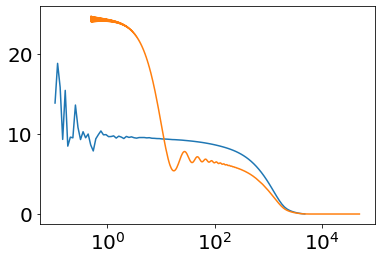

In [18]:
ell = 0
x   = RR.pairs.edges['r']
y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
dx  = np.diff(x)
xc  = 0.5*(x[1:]+x[:-1])
vol = 4*np.pi*xc**2*dx    
y  /= vol

plt.plot(xc, y)

k, w_dicts = read_florian()
Klog = np.logspace(np.log10(k.min()), np.log10(2.0), num=1024, endpoint=True)

wius  = IUS(k, w_dicts['W^0_%d(k)'%ell], ext=1)
wk    = wius(Klog)        
r, wr = mcfit.P2xi(Klog, l=ell)(wk)
plt.plot(r, wr*1.0e11)
plt.xscale('log')
# plt.loglog()

In [23]:
Xi2p = mcfit.xi2P(xc)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/mcfit/mcfit.py:125: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


In [25]:
xik, pk = Xi2p(y)

[]

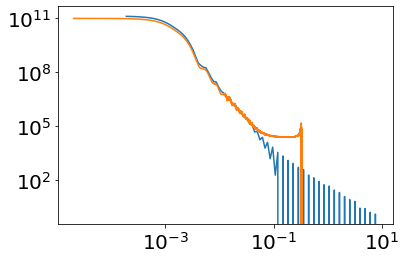

In [29]:
plt.plot(xik, pk)
plt.plot(k, 1.0e11*w_dicts['W^0_0(k)'])
plt.loglog()

[1.80734776 1.82780269 1.84848911 1.86940966 1.89056698 1.91196375
 1.93360268 1.95548651 1.97761802 2.        ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.80734776 1.82780269 1.84848911 1.86940966 1.89056698 1.91196375
 1.93360268 1.95548651 1.97761802 2.        ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.80734776 1.82780269 1.84848911 1.86940966 1.89056698 1.91196375
 1.93360268 1.95548651 1.97761802 2.        ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


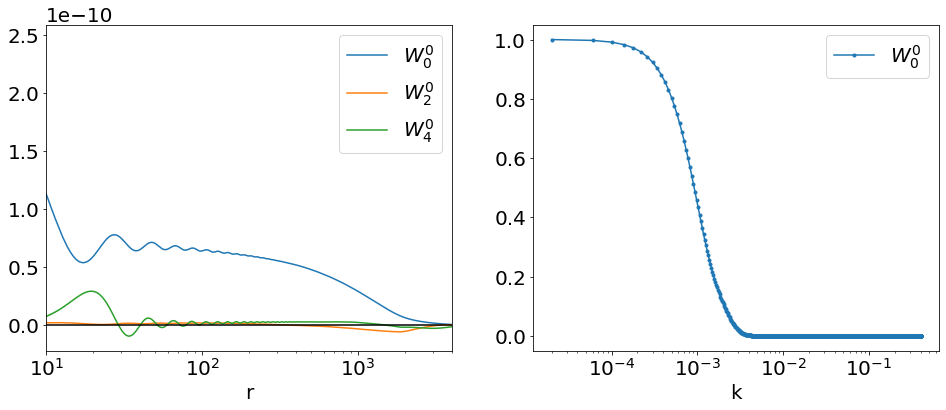

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
plot_W0ellr(k, w_dicts, ax=ax[0])
plot_W0ellk(k, w_dicts, ax=ax[1])
# ax[1].axis([8.e-3, 2.e-2, 0.1, 0.1])

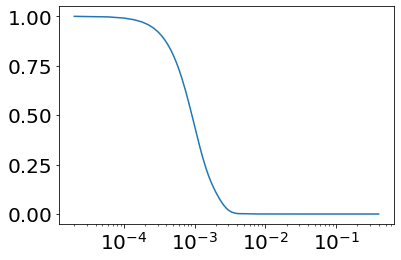

In [49]:
plt.plot(k, w_dicts['W^0_0(k)'])
plt.xscale('log')